# Kellogg Watershed

In [1]:
watershed = 'Kellogg'

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# some_file.py
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')
#import Abnormal_data_values_control 
#from Abnormal_data_values_control import threC
import os
os.getcwd()

path = os.getcwd().rsplit('/',1)[0] +'/RawData/'
path

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/15-Kellogg/RawData/'

In [3]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,9999), 
                'AirTemperature':(-20,50),
                'SolarRadiation':(-50,400),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,100),
                'SoilTemperature': (-5,50), ### avoid unreasonable records
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

### 1. Streamflow

In [4]:
data = pd.read_excel(path +'raw_augusta_creek_discharge.xlsx', header = 0,index_col = 'datetime')
data.head(2)

70446_00060_00003
datetime                     
1964-10-01               21.0
1964-10-02               20.0

In [5]:
prep = copy.deepcopy(data)
prep.columns = ['KBS096_Discharge']
prep = threC(prep,'Discharge')

KBS096_Discharge


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

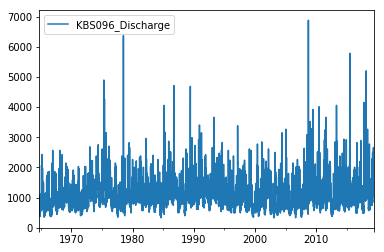

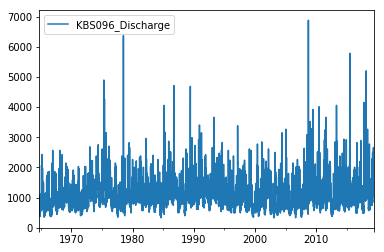

In [6]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Discharge unit should be L/s

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*23.3168  # convert to the right unit(m3/s to L/s)
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'Discharge') 
Discharge = copy.deepcopy(df)
Discharge.plot()

### 2. Precipitation

In [7]:
# 1
data = pd.read_csv('https://lter.kbs.msu.edu/datatables/31.csv',header = 0,index_col = 'Date',skiprows = 35)
display(data.head(2))
data = data.iloc[1:len(data)]
data.index = pd.to_datetime(data.index)
data = data[['Precip_Rain']]
data.columns = ['KBS017_Precipitation']
data.sort_index(inplace = True)
prep1 = pd.DataFrame(pd.to_numeric(data['KBS017_Precipitation'])*25.4) ### to mm
prep1.head(2)

Year Time_of_Observation    Temp_Max    Temp_Min  \
Date                                                             
NaN              #                 NaN  fahrenheit  fahrenheit   
2018-01-31  2018.0                 NaN        41.0        24.0   

           Temp_at_Observation Precip_Rain Precip_Snow Precip_On_Ground  Fog  \
Date                                                                           
NaN                 fahrenheit        inch        inch             inch  NaN   
2018-01-31                40.0         NaN      0.0000           0.0000  NaN   

           Ice_Pellets Glaze Thunder Hail Damaging_Wind Remarks  
Date                                                             
NaN                NaN   NaN     NaN  NaN           NaN     NaN  
2018-01-31         NaN   NaN     NaN  NaN           NaN     NaN

KBS017_Precipitation
Date                            
1948-01-01                13.716
1948-01-02                 4.572

In [8]:
# 2
data = pd.read_csv('https://lter.kbs.msu.edu/datatables/181.csv',header = 0,index_col = 'date',skiprows = 27)
display(data.head(2))
data = data.iloc[1:len(data)]
data.index = pd.to_datetime(data.index)
data = data[['precipitation']]
data.columns = ['KBS064_Precipitation']
data.sort_index(inplace = True)
prep2 = pd.DataFrame(pd.to_numeric(data['KBS064_Precipitation'])*25.4)   ### to mm
prep2.head(2)

temperature_max  temperature_max_flag temperature_min  \
date                                                               
#               fahrenheit                   NaN      fahrenheit   
1887-06-01              68                   NaN              57   

            temperature_min_flag precipitation  precipitation_flag snowfall  \
date                                                                          
#                            NaN          inch                 NaN     inch   
1887-06-01                   NaN          1.47                 NaN      0.0   

            snowfall_flag snowdepth  snowdepth_flag  
date                                                 
#                     NaN      inch             NaN  
1887-06-01            NaN       0.0             NaN

KBS064_Precipitation
date                            
1887-06-01                37.338
1887-06-02                 1.016

In [9]:
# 3
data = pd.read_csv('https://lter.kbs.msu.edu/datatables/12.csv', header = 0,skiprows = 44, index_col = 'date')
display(data.head(2))
data = data.iloc[1:len(data)]
data.index = pd.to_datetime(data.index)
#data.index = pd.to_datetime((pd.to_numeric(data['year'])-1970)*365 + pd.to_numeric(data['doy'])+3,unit='D')
data = pd.DataFrame(pd.to_numeric(data['precipitation']))
data.columns = ['KBS002_Precipitation']
data.sort_index(inplace = True)
prep3 = data[['KBS002_Precipitation']]
prep3.head(2)

precipitation flag_precip Air_temp_mean Flag_Air_Temp_Mean  \
date                                                                    
#             millimeter         NaN       celsius                NaN   
2020-06-11          1.00         NaN          15.1                NaN   

           air_temp_max flag_air_temp_max Air_Temp_Min Flag_Air_Temp_Min  \
date                                                                       
#               celsius               NaN      celsius               NaN   
2020-06-11          NaN               NaN          NaN               NaN   

           Air_Pressure Flag_Air_Pressure  ... Flag_Wind_Speed  \
date                                       ...                   
#              millibar               NaN  ...             NaN   
2020-06-11          973               NaN  ...             NaN   

           Wind_Direction_Mean Flag_Wind_Dir      Solar_Radiation  \
date                                                                
#                       degree           NaN  wattsPerSquareMeter   
2020-06-11               281.3           NaN                 0.70   

           Flag_Sol_Rad                                    PAR Flag_Par  \
date                                                                      
#                   NaN  microEinsteinPerMeterSquaredPerSecond      NaN   
2020-06-11          NaN                                  32.58      NaN   

           soil_temp_5_cm_bare_avg soil_temp_5_cm_sod_avg    Year  
date                                                               
#                          celsius                celsius     NaN  
2020-06-11                    20.6                    NaN  2020.0  

[2 rows x 25 columns]

KBS002_Precipitation
date                            
1988-01-01                   0.0
1988-01-02                   0.0

In [10]:
prep = aggre_and_comb_daily([prep1, prep2, prep3], axis=1, func = "sum") 

The final table is:


KBS017_Precipitation KBS064_Precipitation KBS002_Precipitation
1887-06-01                  NaN               37.338                  NaN
1887-06-02                  NaN                1.016                  NaN

KBS017_Precipitation KBS064_Precipitation KBS002_Precipitation
2020-06-10                  NaN                  NaN                    1
2020-06-11                  NaN                  NaN                    1

KBS017_Precipitation
KBS064_Precipitation
KBS002_Precipitation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

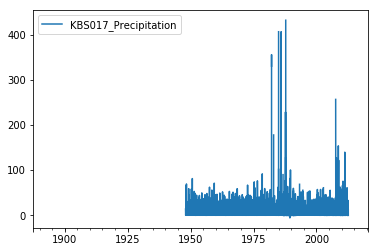

<Figure size 432x288 with 0 Axes>

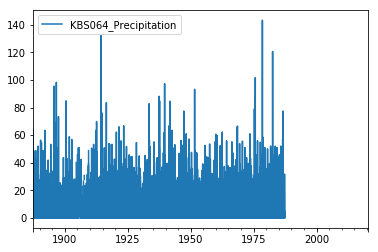

<Figure size 432x288 with 0 Axes>

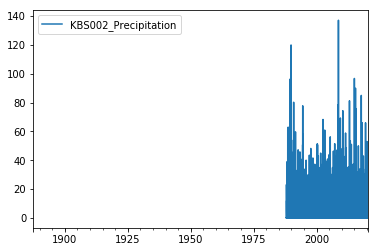

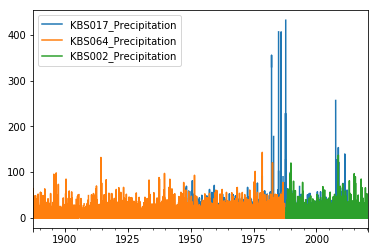

In [11]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Precipitation unit should be mm

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'Precipitation')     
Precipitation = copy.deepcopy(df)
Precipitation.plot()

### 3. AirTemperature

In [12]:
# 1
data = pd.read_csv('https://lter.kbs.msu.edu/datatables/7.csv', header = 0,index_col = 'date',skiprows = 26)
data.head(2)

precipitation flag_precip air_temp_mean flag_air_temp_mean  \
date                                                                    
#             millimeter         NaN       celsius                NaN   
2020-06-11           1.0         NaN         18.82                NaN   

           air_temp_max flag_air_temp_max air_temp_min flag_air_temp_min  \
date                                                                       
#               celsius               NaN      celsius               NaN   
2020-06-11          NaN               NaN          NaN               NaN   

              year  
date                
#              NaN  
2020-06-11  2020.0

In [13]:
data = data.iloc[1:len(data)]
data = pd.DataFrame(pd.to_numeric(data['air_temp_mean']))
data.index=pd.to_datetime(data.index)
data.columns = ['KBS002_AirTemperature']
prep1 = data[['KBS002_AirTemperature']]
prep1.head(2)

KBS002_AirTemperature
date                             
2020-06-11                  18.82
2020-06-10                  24.63

In [14]:
# 2
data = pd.read_csv('https://lter.kbs.msu.edu/datatables/31.csv',header = 0,index_col = 'Date',skiprows = 35)
data.head(2)

Year Time_of_Observation    Temp_Max    Temp_Min  \
Date                                                             
NaN              #                 NaN  fahrenheit  fahrenheit   
2018-01-31  2018.0                 NaN        41.0        24.0   

           Temp_at_Observation Precip_Rain Precip_Snow Precip_On_Ground  Fog  \
Date                                                                           
NaN                 fahrenheit        inch        inch             inch  NaN   
2018-01-31                40.0         NaN      0.0000           0.0000  NaN   

           Ice_Pellets Glaze Thunder Hail Damaging_Wind Remarks  
Date                                                             
NaN                NaN   NaN     NaN  NaN           NaN     NaN  
2018-01-31         NaN   NaN     NaN  NaN           NaN     NaN

In [15]:
data = data.iloc[1:len(data)]
data = pd.DataFrame(pd.to_numeric(data['Temp_at_Observation']))
data.index=pd.to_datetime(data.index)
data.columns = ['KBS017_AirTemperature']
prep2 = (data[['KBS017_AirTemperature']]-32)*5/9
prep2.head(2)

KBS017_AirTemperature
Date                             
2018-01-31               4.444444
2018-01-30              -2.222222

In [16]:
prep = aggre_and_comb_daily([prep1, prep2], axis=1, func = "mean") 

The final table is:


KBS002_AirTemperature KBS017_AirTemperature
1948-01-01                   NaN              -3.33333
1948-01-02                   NaN              -3.88889

KBS002_AirTemperature KBS017_AirTemperature
2020-06-10                 24.63                   NaN
2020-06-11                 18.82                   NaN

KBS002_AirTemperature
KBS017_AirTemperature


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

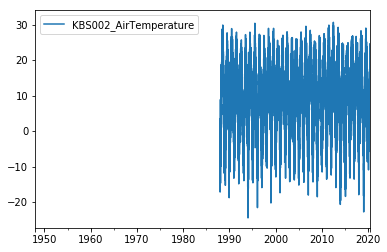

<Figure size 432x288 with 0 Axes>

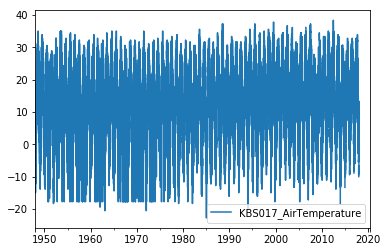

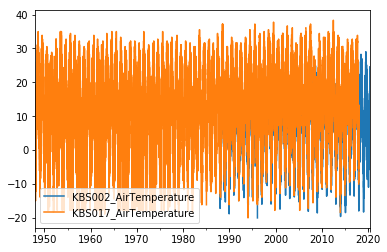

In [17]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Air Temperature unit should be Degree celsius

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'AirTemperature')   
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()

### 4. SolarRadiation

In [18]:
data = pd.read_csv('https://lter.kbs.msu.edu/datatables/12.csv', header = 0,skiprows = 44, index_col = 'date')
data.head(2)

precipitation flag_precip Air_temp_mean Flag_Air_Temp_Mean  \
date                                                                    
#             millimeter         NaN       celsius                NaN   
2020-06-11          1.00         NaN          15.1                NaN   

           air_temp_max flag_air_temp_max Air_Temp_Min Flag_Air_Temp_Min  \
date                                                                       
#               celsius               NaN      celsius               NaN   
2020-06-11          NaN               NaN          NaN               NaN   

           Air_Pressure Flag_Air_Pressure  ... Flag_Wind_Speed  \
date                                       ...                   
#              millibar               NaN  ...             NaN   
2020-06-11          973               NaN  ...             NaN   

           Wind_Direction_Mean Flag_Wind_Dir      Solar_Radiation  \
date                                                                
#                       degree           NaN  wattsPerSquareMeter   
2020-06-11               281.3           NaN                 0.70   

           Flag_Sol_Rad                                    PAR Flag_Par  \
date                                                                      
#                   NaN  microEinsteinPerMeterSquaredPerSecond      NaN   
2020-06-11          NaN                                  32.58      NaN   

           soil_temp_5_cm_bare_avg soil_temp_5_cm_sod_avg    Year  
date                                                               
#                          celsius                celsius     NaN  
2020-06-11                    20.6                    NaN  2020.0  

[2 rows x 25 columns]

In [19]:
data = data.iloc[1:len(data)]
#data.index = pd.to_datetime((pd.to_numeric(data['year'])-1970)*365 + pd.to_numeric(data['doy'])+3,unit='D')
data = pd.DataFrame(pd.to_numeric(data['Solar_Radiation']))
data
data.columns = ['KBS002_SolarRadiation']
prep = data[['KBS002_SolarRadiation']]
prep.head(2)

KBS002_SolarRadiation
date                             
2020-06-11                   0.70
2020-06-10                 138.88

KBS002_SolarRadiation


KBS002_SolarRadiation
1988-01-01                    NaN
1988-01-02                    NaN
1988-01-03                    NaN
1988-01-04                    NaN
1988-01-05                    NaN

<Figure size 720x288 with 0 Axes>

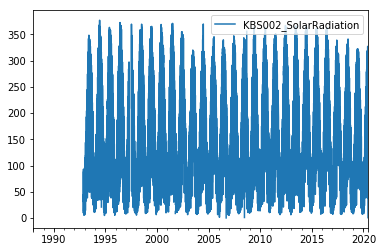

In [20]:
prep = threC(prep,'SolarRadiation')
indexUnique = pd.date_range(str(prep.index[-1]), str(prep.index[0]))
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
 
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
SolarRadiation = copy.deepcopy(df)
SolarRadiation.plot()
SolarRadiation.head()

### 5. Relative Humidity

In [21]:
# 1
data = pd.read_csv('https://lter.kbs.msu.edu/datatables/12.csv', header = 0,skiprows = 44, index_col = 'date')
data.head(2)

precipitation flag_precip Air_temp_mean Flag_Air_Temp_Mean  \
date                                                                    
#             millimeter         NaN       celsius                NaN   
2020-06-11          1.00         NaN          15.1                NaN   

           air_temp_max flag_air_temp_max Air_Temp_Min Flag_Air_Temp_Min  \
date                                                                       
#               celsius               NaN      celsius               NaN   
2020-06-11          NaN               NaN          NaN               NaN   

           Air_Pressure Flag_Air_Pressure  ... Flag_Wind_Speed  \
date                                       ...                   
#              millibar               NaN  ...             NaN   
2020-06-11          973               NaN  ...             NaN   

           Wind_Direction_Mean Flag_Wind_Dir      Solar_Radiation  \
date                                                                
#                       degree           NaN  wattsPerSquareMeter   
2020-06-11               281.3           NaN                 0.70   

           Flag_Sol_Rad                                    PAR Flag_Par  \
date                                                                      
#                   NaN  microEinsteinPerMeterSquaredPerSecond      NaN   
2020-06-11          NaN                                  32.58      NaN   

           soil_temp_5_cm_bare_avg soil_temp_5_cm_sod_avg    Year  
date                                                               
#                          celsius                celsius     NaN  
2020-06-11                    20.6                    NaN  2020.0  

[2 rows x 25 columns]

In [22]:
data = data.iloc[1:len(data)]
#data.index = pd.to_datetime((pd.to_numeric(data['year'])-1970)*365 + pd.to_numeric(data['doy'])+3,unit='D')
data = pd.DataFrame(pd.to_numeric(data['RH']))
data.columns = ['KBS002_RelativeHumidity']
prep = data[['KBS002_RelativeHumidity']]
prep.head(2)

KBS002_RelativeHumidity
date                               
2020-06-11                    92.85
2020-06-10                    76.89

KBS002_RelativeHumidity


KBS002_RelativeHumidity
1988-01-01                      NaN
1988-01-02                      NaN

<Figure size 720x288 with 0 Axes>

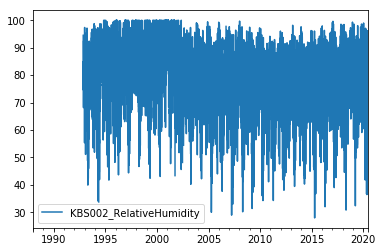

In [23]:
prep = threC(prep,'RelativeHumidity')
indexUnique = pd.date_range(str(prep.index[-1]), str(prep.index[0]))
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
RelativeHumidity = copy.deepcopy(df)
RelativeHumidity.plot()
RelativeHumidity.head(2)

### 6. WindDirection

In [24]:
data = pd.read_csv('https://lter.kbs.msu.edu/datatables/12.csv', header = 0,skiprows = 44, index_col = 'date')
display(data.head(2))
data = data.iloc[1:len(data)]
#data.index = pd.to_datetime((pd.to_numeric(data['year'])-1970)*365 + pd.to_numeric(data['doy'])+3,unit='D')
data = pd.DataFrame(pd.to_numeric(data['Wind_Direction_Mean']))
data.columns = ['KBS002_WindDirection']
prep = data[['KBS002_WindDirection']]
prep.head(2)

precipitation flag_precip Air_temp_mean Flag_Air_Temp_Mean  \
date                                                                    
#             millimeter         NaN       celsius                NaN   
2020-06-11          1.00         NaN          15.1                NaN   

           air_temp_max flag_air_temp_max Air_Temp_Min Flag_Air_Temp_Min  \
date                                                                       
#               celsius               NaN      celsius               NaN   
2020-06-11          NaN               NaN          NaN               NaN   

           Air_Pressure Flag_Air_Pressure  ... Flag_Wind_Speed  \
date                                       ...                   
#              millibar               NaN  ...             NaN   
2020-06-11          973               NaN  ...             NaN   

           Wind_Direction_Mean Flag_Wind_Dir      Solar_Radiation  \
date                                                                
#                       degree           NaN  wattsPerSquareMeter   
2020-06-11               281.3           NaN                 0.70   

           Flag_Sol_Rad                                    PAR Flag_Par  \
date                                                                      
#                   NaN  microEinsteinPerMeterSquaredPerSecond      NaN   
2020-06-11          NaN                                  32.58      NaN   

           soil_temp_5_cm_bare_avg soil_temp_5_cm_sod_avg    Year  
date                                                               
#                          celsius                celsius     NaN  
2020-06-11                    20.6                    NaN  2020.0  

[2 rows x 25 columns]

KBS002_WindDirection
date                            
2020-06-11                 281.3
2020-06-10                 206.3

KBS002_WindDirection


KBS002_WindDirection
1988-01-01                   NaN
1988-01-02                   NaN

<Figure size 720x288 with 0 Axes>

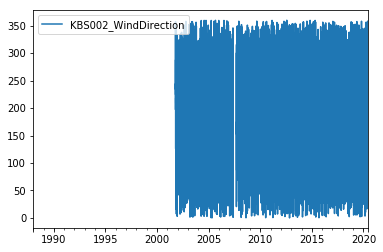

In [25]:
prep = threC(prep,'WindDirection')
indexUnique = pd.date_range(str(prep.index[-1]), str(prep.index[0]))
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
WindDirection = copy.deepcopy(df)
WindDirection.plot()
WindDirection.head(2)

### 7. WindSpeed

In [26]:
data = pd.read_csv('https://lter.kbs.msu.edu/datatables/12.csv', header = 0,skiprows = 44, index_col = 'date')
display(data.head(2))
data = data.iloc[1:len(data)]
#data.index = pd.to_datetime((pd.to_numeric(data['year'])-1970)*365 + pd.to_numeric(data['doy'])+3,unit='D')
data = pd.DataFrame(pd.to_numeric(data['Wind_Speed_Mean']))
data.columns = ['KBS002_WindSpeed']
prep = data[['KBS002_WindSpeed']]
prep.head(2)

precipitation flag_precip Air_temp_mean Flag_Air_Temp_Mean  \
date                                                                    
#             millimeter         NaN       celsius                NaN   
2020-06-11          1.00         NaN          15.1                NaN   

           air_temp_max flag_air_temp_max Air_Temp_Min Flag_Air_Temp_Min  \
date                                                                       
#               celsius               NaN      celsius               NaN   
2020-06-11          NaN               NaN          NaN               NaN   

           Air_Pressure Flag_Air_Pressure  ... Flag_Wind_Speed  \
date                                       ...                   
#              millibar               NaN  ...             NaN   
2020-06-11          973               NaN  ...             NaN   

           Wind_Direction_Mean Flag_Wind_Dir      Solar_Radiation  \
date                                                                
#                       degree           NaN  wattsPerSquareMeter   
2020-06-11               281.3           NaN                 0.70   

           Flag_Sol_Rad                                    PAR Flag_Par  \
date                                                                      
#                   NaN  microEinsteinPerMeterSquaredPerSecond      NaN   
2020-06-11          NaN                                  32.58      NaN   

           soil_temp_5_cm_bare_avg soil_temp_5_cm_sod_avg    Year  
date                                                               
#                          celsius                celsius     NaN  
2020-06-11                    20.6                    NaN  2020.0  

[2 rows x 25 columns]

KBS002_WindSpeed
date                        
2020-06-11              6.74
2020-06-10              6.18

KBS002_WindSpeed


KBS002_WindSpeed
1988-01-01               NaN
1988-01-02               NaN

<Figure size 720x288 with 0 Axes>

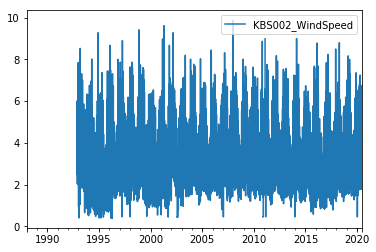

In [27]:
prep = threC(prep,'WindSpeed')
indexUnique = pd.date_range(str(prep.index[-1]), str(prep.index[0]))
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
WindSpeed = copy.deepcopy(df)
WindSpeed.plot()
WindSpeed.head(2)

### 8.SWE

### 9. Snow Depth

In [28]:
# 1 
data = pd.read_csv('https://lter.kbs.msu.edu/datatables/181.csv',header = 0,index_col = 'date',skiprows = 27)
display(data.head(2))
data = data.iloc[1:len(data)]
data.index = pd.to_datetime(data.index)
data = data[['snowfall']]
data.columns = ['KBS064_SnowDepth']
data.sort_index(inplace = True)
prep1 = pd.DataFrame(pd.to_numeric(data['KBS064_SnowDepth'])*25.4)   ### to mm
prep1.head(2)

temperature_max  temperature_max_flag temperature_min  \
date                                                               
#               fahrenheit                   NaN      fahrenheit   
1887-06-01              68                   NaN              57   

            temperature_min_flag precipitation  precipitation_flag snowfall  \
date                                                                          
#                            NaN          inch                 NaN     inch   
1887-06-01                   NaN          1.47                 NaN      0.0   

            snowfall_flag snowdepth  snowdepth_flag  
date                                                 
#                     NaN      inch             NaN  
1887-06-01            NaN       0.0             NaN

KBS064_SnowDepth
date                        
1887-06-01               0.0
1887-06-02               0.0

In [29]:
# 2
data = pd.read_csv('https://lter.kbs.msu.edu/datatables/529.csv',header = 0,index_col = 'date',skiprows = 20)
display(data.head(2))

year snow_precipitation_mm snow_depth_mm
date                                                
NaN            #            millimeter    millimeter
2010-12-03  2011                   NaN           NaN

In [30]:
data = data.iloc[1:len(data)]
data.index = pd.to_datetime(data.index)
data = data[['snow_depth_mm']]
data.columns = ['KBS119_SnowDepth']
data.sort_index(inplace = True)
prep2 = pd.DataFrame(pd.to_numeric(data['KBS119_SnowDepth']))  
prep2.head(2)

KBS119_SnowDepth
date                        
2010-12-03               NaN
2010-12-04               NaN

The final table is:


KBS064_SnowDepth KBS119_SnowDepth
1887-06-01                0              NaN
1887-06-02                0              NaN

KBS064_SnowDepth KBS119_SnowDepth
2013-03-25              NaN              NaN
2013-03-26              NaN              NaN

KBS064_SnowDepth
KBS119_SnowDepth


KBS064_SnowDepth  KBS119_SnowDepth
1887-06-01             40.64               NaN
1887-06-02              0.00               NaN

<Figure size 720x288 with 0 Axes>

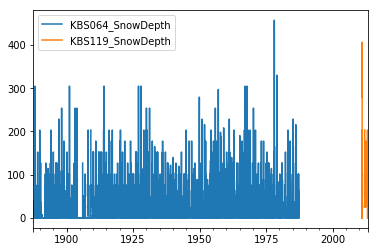

In [31]:
prep = threC(prep,'SnowDepth')
prep = aggre_and_comb_daily([prep1,prep2], axis=1, func = "mean") 
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
SnowDepth = copy.deepcopy(df)
SnowDepth.plot()
SnowDepth.head(2)

### 10. Vapor Pressure

### 11. Soil Moisture

In [32]:
data = pd.read_csv('https://lter.kbs.msu.edu/datatables/30.csv', header = 0,index_col= 'date',skiprows = 28)
display(data.head(2))

treatment replicate      moisture    year comments
date                                                         
#                NaN       NaN  gramsPerGram     NaN      NaN
1989-04-18        T1        R1          0.20  1989.0      NaN

In [33]:
data = data.iloc[1:len(data)]
data.index = pd.to_datetime(data.index)
#data.index = pd.to_datetime((pd.to_numeric(data['year'])-1970)*365 + pd.to_numeric(data['doy'])+3,unit='D')
data = pd.DataFrame(pd.to_numeric(data['moisture']))
data = data.groupby(data.index.date).mean()
data.index=pd.to_datetime(data.index)
data.columns = ['KBS015_SoilMoisture']
prep1= copy.deepcopy(data)
prep1.head()

KBS015_SoilMoisture
1989-04-18             0.203043
1989-05-23             0.125435
1989-06-21             0.156667
1989-07-25             0.123261
1989-08-24             0.145909

In [34]:
prep1.tail(2)

KBS015_SoilMoisture
2018-10-17             0.170727
2018-11-12             0.191091

In [35]:
# 2
data = pd.read_csv('https://lter.kbs.msu.edu/datatables/157.csv', header = 0,index_col ='date',skiprows = 22)
display(data.head(2))

treatment  replicate sub_plot      moisture comments
date                                                           
#                NaN        NaN      NaN  gramsPerGram      NaN
2018-11-09       8          2.0      NaN          0.27      NaN

In [36]:
data = data.iloc[1:len(data)]
data.index = pd.to_datetime(data.index)
#data.index = pd.to_datetime((pd.to_numeric(data['year'])-1970)*365 + pd.to_numeric(data['doy'])+3,unit='D')
data = pd.DataFrame(pd.to_numeric(data['moisture']))
data = data.groupby(data.index.date).mean()
data.index=pd.to_datetime(data.index)
data.columns = ['KBS013_SoilMoisture']
prep2= copy.deepcopy(data)
prep2.head()

KBS013_SoilMoisture
2003-03-31             0.192000
2003-04-16             0.163226
2003-04-29             0.135806
2003-05-14             0.399310
2003-05-30             0.150000

In [37]:
prep2.tail(2)

KBS013_SoilMoisture
2018-10-05                0.146
2018-11-09                0.194

The final table is:


KBS015_SoilMoisture KBS013_SoilMoisture
1989-04-18            0.203043                 NaN
1989-05-23            0.125435                 NaN

KBS015_SoilMoisture KBS013_SoilMoisture
2018-11-09                 NaN               0.194
2018-11-12            0.191091                 NaN

KBS015_SoilMoisture
KBS013_SoilMoisture


KBS015_SoilMoisture  KBS013_SoilMoisture
1989-04-18            20.304348                  NaN
1989-04-19                  NaN                  NaN

<Figure size 720x288 with 0 Axes>

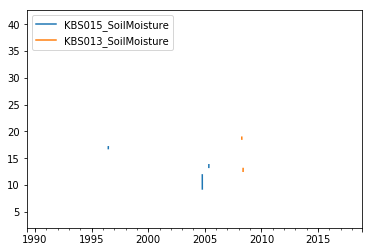

In [38]:
prep = aggre_and_comb_daily([prep1,prep2], axis=1, func = "mean") 
prep = threC(prep,'SoilMoisture')

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  

        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*100 # 
                       
SoilMoisture = copy.deepcopy(df)
SoilMoisture.plot()
SoilMoisture.head(2)

### 12. Soil Temperature

In [39]:
data = pd.read_csv('https://lter.kbs.msu.edu/datatables/12.csv', header = 0,skiprows = 44, index_col = 'date')
display(data.head(2))
data = data.iloc[1:len(data)]
#data.index = pd.to_datetime((pd.to_numeric(data['year'])-1970)*365 + pd.to_numeric(data['doy'])+3,unit='D')
data = pd.DataFrame(pd.to_numeric(data['soil_temp_5_cm_bare_avg']))
data.index=pd.to_datetime(data.index)
data.columns = ['KBS002_SoilTemperature_5cmbare']
prep1 = copy.deepcopy(data)
prep1.head(2)

precipitation flag_precip Air_temp_mean Flag_Air_Temp_Mean  \
date                                                                    
#             millimeter         NaN       celsius                NaN   
2020-06-11          1.00         NaN          15.1                NaN   

           air_temp_max flag_air_temp_max Air_Temp_Min Flag_Air_Temp_Min  \
date                                                                       
#               celsius               NaN      celsius               NaN   
2020-06-11          NaN               NaN          NaN               NaN   

           Air_Pressure Flag_Air_Pressure  ... Flag_Wind_Speed  \
date                                       ...                   
#              millibar               NaN  ...             NaN   
2020-06-11          973               NaN  ...             NaN   

           Wind_Direction_Mean Flag_Wind_Dir      Solar_Radiation  \
date                                                                
#                       degree           NaN  wattsPerSquareMeter   
2020-06-11               281.3           NaN                 0.70   

           Flag_Sol_Rad                                    PAR Flag_Par  \
date                                                                      
#                   NaN  microEinsteinPerMeterSquaredPerSecond      NaN   
2020-06-11          NaN                                  32.58      NaN   

           soil_temp_5_cm_bare_avg soil_temp_5_cm_sod_avg    Year  
date                                                               
#                          celsius                celsius     NaN  
2020-06-11                    20.6                    NaN  2020.0  

[2 rows x 25 columns]

KBS002_SoilTemperature_5cmbare
date                                      
2020-06-11                            20.6
2020-06-10                            26.4

In [40]:
data = pd.read_csv('https://lter.kbs.msu.edu/datatables/12.csv', header = 0,skiprows = 44, index_col = 'date')
display(data.head(2))
data = data.iloc[1:len(data)]
#data.index = pd.to_datetime((pd.to_numeric(data['year'])-1970)*365 + pd.to_numeric(data['doy'])+3,unit='D')
data = pd.DataFrame(pd.to_numeric(data['soil_temp_5_cm_sod_avg']))
data.index=pd.to_datetime(data.index)
data.columns = ['KBS002_SoilTemperature_5cmsod']
prep2 = copy.deepcopy(data)
prep2.head(2)

precipitation flag_precip Air_temp_mean Flag_Air_Temp_Mean  \
date                                                                    
#             millimeter         NaN       celsius                NaN   
2020-06-11          1.00         NaN          15.1                NaN   

           air_temp_max flag_air_temp_max Air_Temp_Min Flag_Air_Temp_Min  \
date                                                                       
#               celsius               NaN      celsius               NaN   
2020-06-11          NaN               NaN          NaN               NaN   

           Air_Pressure Flag_Air_Pressure  ... Flag_Wind_Speed  \
date                                       ...                   
#              millibar               NaN  ...             NaN   
2020-06-11          973               NaN  ...             NaN   

           Wind_Direction_Mean Flag_Wind_Dir      Solar_Radiation  \
date                                                                
#                       degree           NaN  wattsPerSquareMeter   
2020-06-11               281.3           NaN                 0.70   

           Flag_Sol_Rad                                    PAR Flag_Par  \
date                                                                      
#                   NaN  microEinsteinPerMeterSquaredPerSecond      NaN   
2020-06-11          NaN                                  32.58      NaN   

           soil_temp_5_cm_bare_avg soil_temp_5_cm_sod_avg    Year  
date                                                               
#                          celsius                celsius     NaN  
2020-06-11                    20.6                    NaN  2020.0  

[2 rows x 25 columns]

KBS002_SoilTemperature_5cmsod
date                                     
2020-06-11                            NaN
2020-06-10                            NaN

The final table is:


KBS002_SoilTemperature_5cmbare KBS002_SoilTemperature_5cmsod
1988-01-01                            NaN                           NaN
1988-01-02                            NaN                           NaN

KBS002_SoilTemperature_5cmbare KBS002_SoilTemperature_5cmsod
2020-06-10                           26.4                           NaN
2020-06-11                           20.6                           NaN

KBS002_SoilTemperature_5cmbare
KBS002_SoilTemperature_5cmsod


KBS002_SoilTemperature_5cmbare  KBS002_SoilTemperature_5cmsod
1988-01-01                             NaN                            NaN
1988-01-02                             NaN                            NaN

<Figure size 720x288 with 0 Axes>

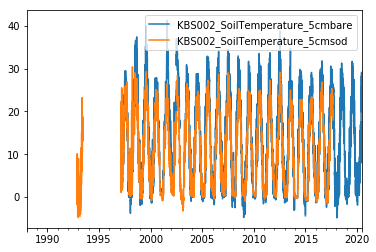

In [41]:
prep = aggre_and_comb_daily([prep1,prep2], axis=1, func = "mean") 
prep = threC(prep,'SoilTemperature')

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
SoilTemperature = copy.deepcopy(df)
SoilTemperature.plot()
SoilTemperature.head(2)

### 13. Isotope

# All Results

In [42]:
result = pd.concat([Discharge,Precipitation,AirTemperature,SolarRadiation,RelativeHumidity, 
                    WindDirection, WindSpeed,
                    SnowDepth,
                    SoilTemperature],
                    axis=1,
                    join='outer')######
result.index.rename('DateTime',inplace = True)
result.head()

KBS096_Discharge  KBS017_Precipitation  KBS064_Precipitation  \
DateTime                                                                   
1887-06-01               NaN                 4.318                 1.778   
1887-06-02               NaN                   NaN                 1.016   
1887-06-03               NaN                   NaN                 0.000   
1887-06-04               NaN                   NaN                 0.000   
1887-06-05               NaN                   NaN                 9.652   

            KBS002_Precipitation  KBS002_AirTemperature  \
DateTime                                                  
1887-06-01                   NaN                    NaN   
1887-06-02                   NaN                    NaN   
1887-06-03                   NaN                    NaN   
1887-06-04                   NaN                    NaN   
1887-06-05                   NaN                    NaN   

            KBS017_AirTemperature  KBS002_SolarRadiation  \
DateTime                                                   
1887-06-01                    NaN                    NaN   
1887-06-02                    NaN                    NaN   
1887-06-03                    NaN                    NaN   
1887-06-04                    NaN                    NaN   
1887-06-05                    NaN                    NaN   

            KBS002_RelativeHumidity  KBS002_WindDirection  KBS002_WindSpeed  \
DateTime                                                                      
1887-06-01                      NaN                   NaN               NaN   
1887-06-02                      NaN                   NaN               NaN   
1887-06-03                      NaN                   NaN               NaN   
1887-06-04                      NaN                   NaN               NaN   
1887-06-05                      NaN                   NaN               NaN   

            KBS064_SnowDepth  KBS119_SnowDepth  \
DateTime                                         
1887-06-01             40.64               NaN   
1887-06-02              0.00               NaN   
1887-06-03              0.00               NaN   
1887-06-04              0.00               NaN   
1887-06-05              0.00               NaN   

            KBS002_SoilTemperature_5cmbare  KBS002_SoilTemperature_5cmsod  
DateTime                                                                   
1887-06-01                             NaN                            NaN  
1887-06-02                             NaN                            NaN  
1887-06-03                             NaN                            NaN  
1887-06-04                             NaN                            NaN  
1887-06-05                             NaN                            NaN

In [43]:
result.to_csv('1_Kellogg_Download_Aggregation_Daily.csv', sep=',')
SoilMoisture.to_csv('1_Kellogg_Download_SoilMoisture_weekly.csv', sep=',')